# Modeling

First thing, I want to see what the simplest, baseline model for my data is. To do this, I will just find whatever I have that correlates the most with PRICE and then create a model with it.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import functions

In [3]:
# Import data
kc = pd.read_csv('../../Data/matthew_clean_data.csv', index_col=0)

In [4]:
# Create Correlation matrix
kc_matrix = kc.corr()
kc_matrix['price']

id             -0.016772
price           1.000000
grade           0.667951
yr_built        0.053953
yr_renovated    0.125499
floors_1.5      0.015896
floors_2.0      0.232696
floors_2.5      0.122845
floors_3.0      0.020036
floors_3.5      0.018132
Name: price, dtype: float64

## Simple Model: Price ~ Grade

In [5]:
# Grade seems to have the highest correlation here. Let's start there

#Train/Test Split
X = kc.drop(columns=['price', 'date', 'yr_renovated'])
y = kc['price']

# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33)

model = sm.OLS(y_train, sm.add_constant(X_train['grade'])).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                 1.159e+04
Date:                Wed, 06 Oct 2021   Prob (F-statistic):               0.00
Time:                        15:00:34   Log-Likelihood:            -2.0168e+05
No. Observations:               14469   AIC:                         4.034e+05
Df Residuals:                   14467   BIC:                         4.034e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.343e+05   9333.066    -46.534      0.000   -4.53e+05   -4.16e+05
grade       2.092e+05   1942.769    107.659      0.000    2.05e+05    2.13e+05
==============================================================================
Omnibus:                    14114.796   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1939529.630
Skew:                           4.396   Prob(JB):                         0.00
Kurtosis:                      59.034   Cond. No.                         20.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
# For comparing the models, let's also use our evaluate() function to get R2, RMSE, MAE
train_preds = model.predict(sm.add_constant(X_train['grade']))
test_preds = model.predict(sm.add_constant(X_test['grade']))
functions.evaluate(y_train, train_preds, y_test, test_preds)

Train R2: 0.4448
Test R2: 0.4489
****
Train RMSE: $273,792.94
Test RMSE: $272,574.17
****
Train MAE: $174,774.87
Test MAE: $176,121.46


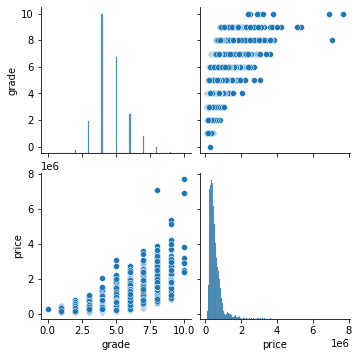

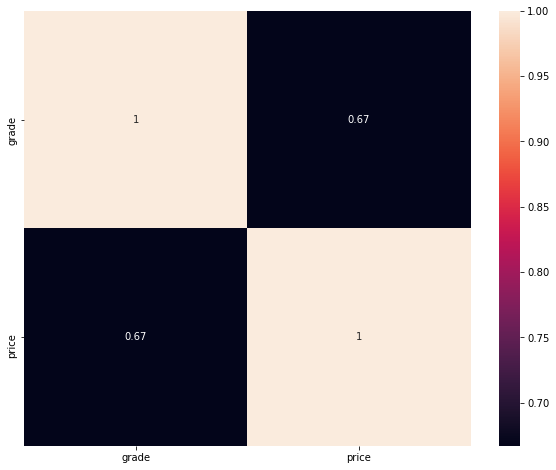

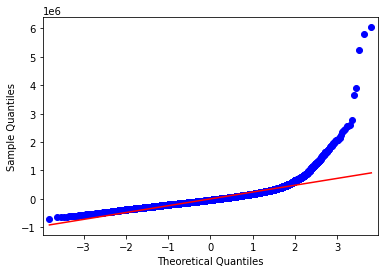

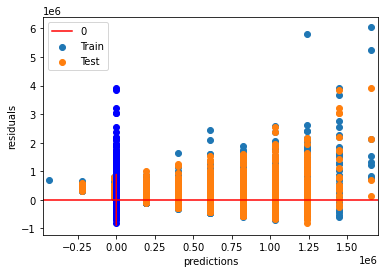

In [7]:
# Let's also check the assumptions of linearity.
functions.check_assumptions(X_train['grade'], y_train, train_preds, test_preds, y_test)

## Conclusion
Looking at the results two things stick out to me:
- The RMSE and MAE have a difference of about $98,000 dollars.

- This model violates the "residual normality" assumption of linear regression. The Jarque-Bera score of 1,991,063 also reinforces this.
- It may also have some heteroscedasticity as well, violating another assumption.

This is definitely a good start, but I think it would benefit any model moving forward to remove the extreme outliers.

## (Price ~ Grade) with removed outliers

In [8]:
# Remove the 5% most expensive houses
kc_trim = kc[kc['price'] < kc['price'].quantile(0.95)]

# Redo the Train/Test Split and exclude outliers
X = kc_trim.drop(columns=['price', 'date', 'yr_renovated'])
y = kc_trim['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33)

model = sm.OLS(y_train, sm.add_constant(X_train['grade'])).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.399
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     9136.
Date:                Wed, 06 Oct 2021   Prob (F-statistic):               0.00
Time:                        15:00:41   Log-Likelihood:            -1.8454e+05
No. Observations:               13743   AIC:                         3.691e+05
Df Residuals:                   13741   BIC:                         3.691e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.029e+05   6248.621    -16.471      0.000   -1.15e+05   -9.07e+04
grade       1.284e+05   1343.353     95.582      0.000    1.26e+05    1.31e+05
==============================================================================
Omnibus:                     1055.684   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1341.690
Skew:                           0.702   Prob(JB):                    4.53e-292
Kurtosis:                       3.609   Cond. No.                         21.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
train_preds = model.predict(sm.add_constant(X_train['grade']))
test_preds = model.predict(sm.add_constant(X_test['grade']))
functions.evaluate(y_train, train_preds, y_test, test_preds)

Train R2: 0.3994
Test R2: 0.4148
****
Train RMSE: $164,188.77
Test RMSE: $160,575.67
****
Train MAE: $129,390.35
Test MAE: $127,484.14


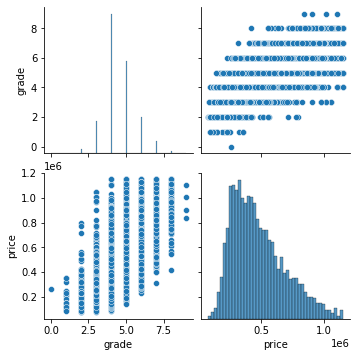

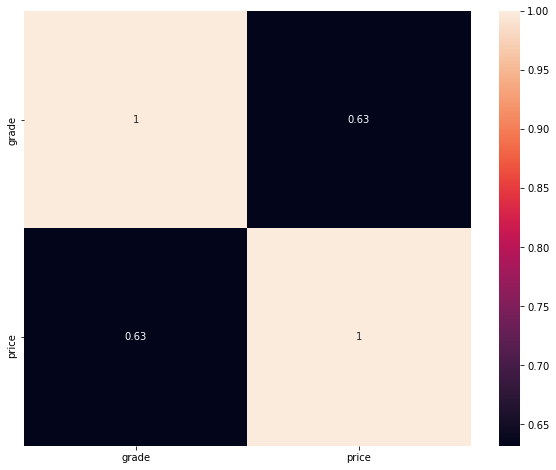

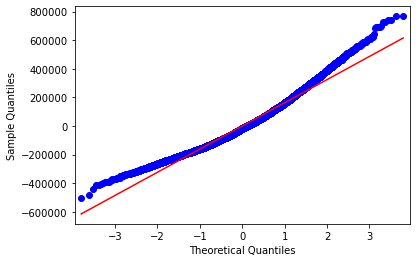

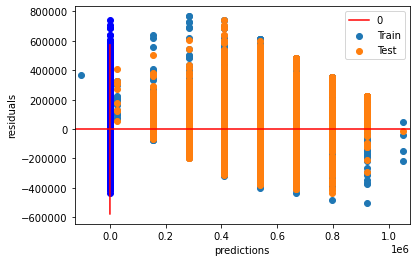

In [10]:
functions.check_assumptions(X_train['grade'], y_train, train_preds, test_preds, y_test)

## Conclusion
This test is interesting:
- The R-Squared went down by about 0.082

but:
- our RMSE went down by about $111,000
- our MSE went down by abour $47,000
- The model still violates the “residual normality” assumption of linear regression. However The Jarque-Bera is now 1270, *much* lower then the previous score of 1,991,063!
- The heteroscedasticity still seems to be present

Overall, I'd say this is an improvement! I think it would be smart to remove outliers like I've done here for any models moving forward. I think it would also be possible to tune the quantile I use to further improve accuracy. For now, I think it'd be better to move on.

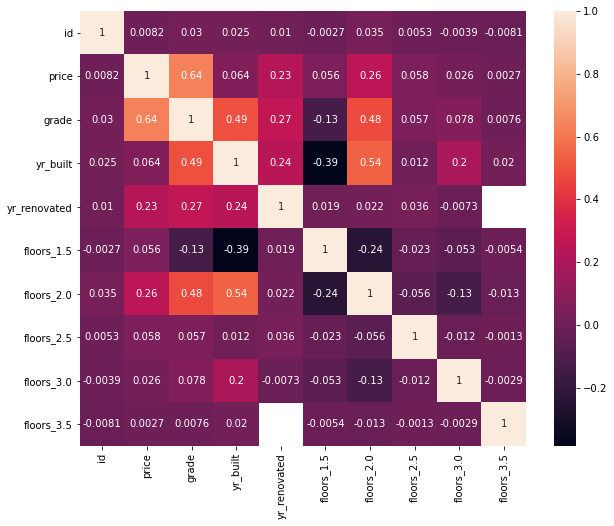

In [11]:
# Before moving forward, I'd like to check the correlation matrix again with removed outliers
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(kc_trim.corr(), annot=True, )
plt.show()

## Renovated
Interestingly, there has been a general uptick in correlations. I think it would be a good idea to investigate the "yr_renovated" column. But let's instead create a column that indicated if a house has been renovated at all, and see if there's any correlation there.

In [12]:
kc_trim['renovated'] = kc_trim['yr_renovated'].notna().astype(int)

<ipython-input-12-f37bbce968aa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kc_trim['renovated'] = kc_trim['yr_renovated'].notna().astype(int)


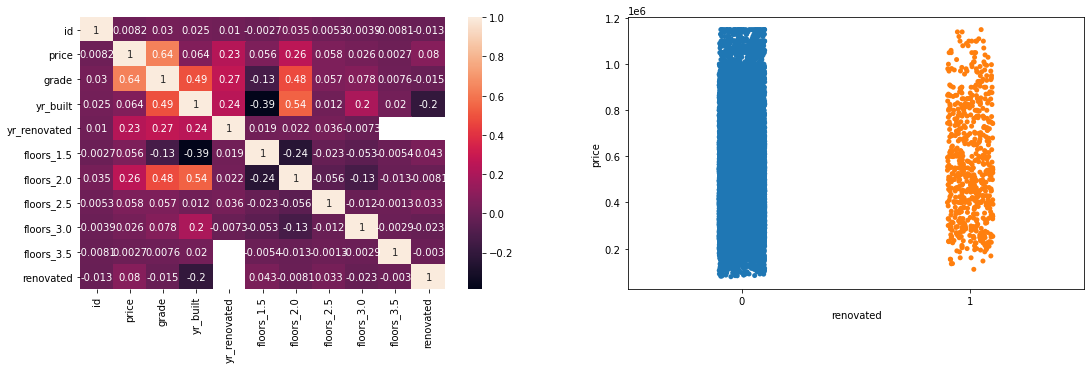

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
sns.heatmap(kc_trim.corr(), annot=True, ax=ax1)
sns.stripplot(data=kc_trim, x='renovated', y='price', ax=ax2)
plt.show()

an interesting feature, but doesn't look anymore useful then 'yr_renovated'

# Price ~ grade + floors_2.0
I'd like to see if adding 'floors_2.0' to our previous model will result in an improvement.

In [14]:
# No need to re-split since this is a new model
model = sm.OLS(y_train, sm.add_constant(X_train[['grade', 'floors_2.0']])).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     4624.
Date:                Wed, 06 Oct 2021   Prob (F-statistic):               0.00
Time:                        15:00:53   Log-Likelihood:            -1.8450e+05
No. Observations:               13743   AIC:                         3.690e+05
Df Residuals:                   13740   BIC:                         3.690e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.203e+05   6580.104    -18.284      0.000   -1.33e+05   -1.07e+05
grade       1.344e+05   1527.374     88.025      0.000    1.31e+05    1.37e+05
floors_2.0 -2.725e+04   3302.832     -8.251      0.000   -3.37e+04   -2.08e+04
==============================================================================
Omnibus:                     1051.302   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1339.973
Skew:                           0.697   Prob(JB):                    1.07e-291
Kurtosis:                       3.630   Cond. No.                         23.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
train_preds = model.predict(sm.add_constant(X_train[['grade', 'floors_2.0']]))
test_preds = model.predict(sm.add_constant(X_test[['grade', 'floors_2.0']]))
functions.evaluate(y_train, train_preds, y_test, test_preds)

Train R2: 0.4023
Test R2: 0.4178
****
Train RMSE: $163,783.54
Test RMSE: $160,162.27
****
Train MAE: $128,988.68
Test MAE: $126,988.02


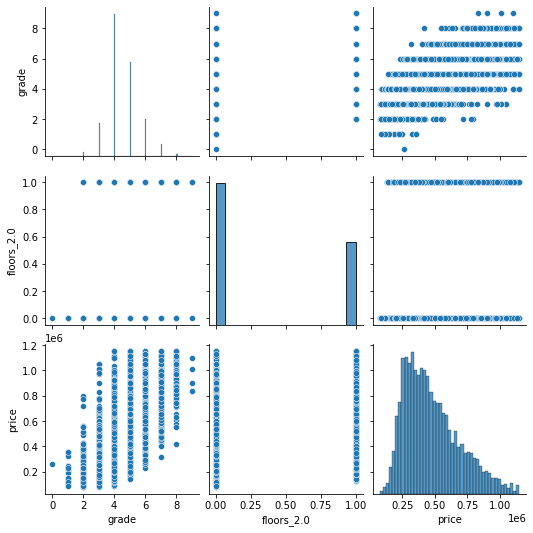

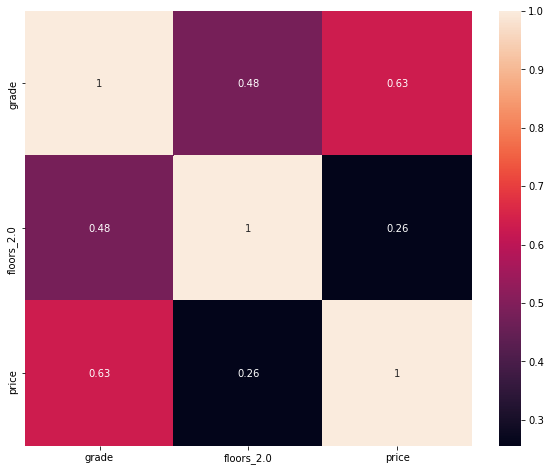

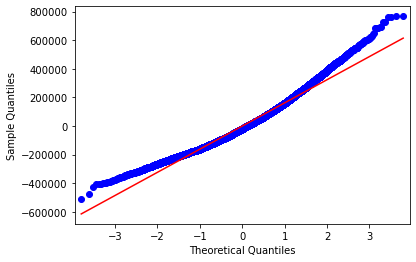

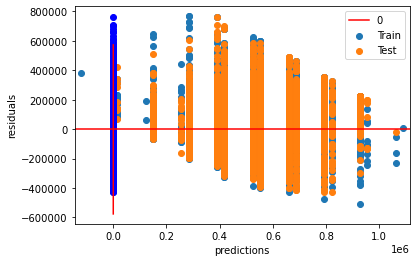

In [16]:
functions.check_assumptions(X_train[['grade', 'floors_2.0']], y_train, train_preds, test_preds, y_test)

## Conclusion
Overall, a **very small** increase in performance across all categories, but it still containes the same issues as the previous model (assumptions of linearity). This is an improvement for sure, however, I think it would be more effective to move on to combining what I have here with some of my partners' models. I think that any more experimintation here would only result in minor increase to performance, as seen in this last model.

In [17]:
model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     1652.
Date:                Wed, 06 Oct 2021   Prob (F-statistic):               0.00
Time:                        15:01:02   Log-Likelihood:            -1.8341e+05
No. Observations:               13743   AIC:                         3.668e+05
Df Residuals:                   13734   BIC:                         3.669e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.057e+06   1.19e+05     42.477      0.000    4.82e+06    5.29e+06
id         -6.299e-07   4.49e-07     -1.404      0.160   -1.51e-06     2.5e-07
grade       1.549e+05   1503.197    103.033      0.000    1.52e+05    1.58e+05
yr_built   -2688.8489     61.576    -43.667      0.000   -2809.546   -2568.152
floors_1.5  2.748e+04   4986.397      5.510      0.000    1.77e+04    3.72e+04
floors_2.0  4.748e+04   3512.764     13.517      0.000    4.06e+04    5.44e+04
floors_2.5  7.057e+04   1.83e+04      3.860      0.000    3.47e+04    1.06e+05
floors_3.0  7.091e+04   8423.177      8.418      0.000    5.44e+04    8.74e+04
floors_3.5  6.624e+04   7.57e+04      0.875      0.382   -8.22e+04    2.15e+05
==============================================================================
Omnibus:                      892.054   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1198.016
Skew:                           0.586   Prob(JB):                    7.15e-261
Kurtosis:                       3.846   Cond. No.                     5.01e+11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.01e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [59]:
s = pd.read_csv('../../Data/my_filtered_dataframe_id.csv', index_col=0)
t = pd.read_csv('../../Data/cleanhousedata_id.csv', index_col=0)
s

,id,price,date,yr_renovated,yr_built,condition,grade,view,waterfront,zipcode,lat,long,cat_waterfront,cat_view,cat_condition,cat_grade,cat_zipcode
0,7129300520,221900.0,10/13/2014,NaN,1955,3,4,NONE,NaN,98178,47.5112,-122.257,NaN,NONE,Average,7 Average,98178
1,6414100192,538000.0,12/9/2014,1991.0,1951,3,4,NONE,NO,98125,47.7210,-122.319,NO,NONE,Average,7 Average,98125
2,5631500400,180000.0,2/25/2015,NaN,1933,3,3,NONE,NO,98028,47.7379,-122.233,NO,NONE,Average,6 Low Average,98028
3,2487200875,604000.0,12/9/2014,NaN,1965,5,4,NONE,NO,98136,47.5208,-122.393,NO,NONE,Very Good,7 Average,98136
4,1954400510,510000.0,2/18/2015,NaN,1987,3,5,NONE,NO,98074,47.6168,-122.045,NO,NONE,Average,8 Good,98074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,360000.0,5/21/2014,NaN,2009,3,5,NONE,NO,98103,47.6993,-122.346,NO,NONE,Average,8 Good,98103
21593,6600060120,400000.0,2/23/2015,NaN,2014,3,5,NONE,NO,98146,47.5107,-122.362,NO,NONE,Average,8 Good,98146
21594,1523300141,402101.0,6/23/2014,NaN,2009,3,4,NONE,NO,98144,47.5944,-122.299,NO,NONE,Average,7 Average,98144
21595,291310100,400000.0,1/16/2015,NaN,2004,3,5,NONE,NaN,98027,47.5345,-122.069,NaN,NONE,Average,8 Good,98027


In [60]:
#t = t.drop(axis=1, labels=['price'])
t.set_index('id')
kc.set_index('id')
kct = kc_trim.merge(t, on='id')

In [61]:
s.set_index('id')
all_clean = kct.merge(s, on='id')

In [62]:
all_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18183 entries, 0 to 18182
Data columns (total 34 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              18183 non-null  int64  
 1   price_x         18183 non-null  float64
 2   grade_x         18183 non-null  int64  
 3   date_x          18183 non-null  object 
 4   yr_built_x      18183 non-null  int64  
 5   yr_renovated_x  452 non-null    float64
 6   floors_1.5      18183 non-null  int64  
 7   floors_2.0      18183 non-null  int64  
 8   floors_2.5      18183 non-null  int64  
 9   floors_3.0      18183 non-null  int64  
 10  floors_3.5      18183 non-null  int64  
 11  renovated       18183 non-null  int64  
 12  price_y         18183 non-null  float64
 13  view_x          18183 non-null  object 
 14  sqft_living     18183 non-null  int64  
 15  sqft_lot        18183 non-null  int64  
 16  bedrooms        18183 non-null  int64  
 17  bathrooms       18183 non-null 

In [63]:
all_clean.drop(axis=1, labels=['view_y', 'price_y', 'grade_y', 'yr_built_y', 'date_y', 'yr_renovated'], inplace=True)

In [64]:
all_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18183 entries, 0 to 18182
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              18183 non-null  int64  
 1   price_x         18183 non-null  float64
 2   grade_x         18183 non-null  int64  
 3   date_x          18183 non-null  object 
 4   yr_built_x      18183 non-null  int64  
 5   yr_renovated_x  452 non-null    float64
 6   floors_1.5      18183 non-null  int64  
 7   floors_2.0      18183 non-null  int64  
 8   floors_2.5      18183 non-null  int64  
 9   floors_3.0      18183 non-null  int64  
 10  floors_3.5      18183 non-null  int64  
 11  renovated       18183 non-null  int64  
 12  view_x          18183 non-null  object 
 13  sqft_living     18183 non-null  int64  
 14  sqft_lot        18183 non-null  int64  
 15  bedrooms        18183 non-null  int64  
 16  bathrooms       18183 non-null  int64  
 17  price           18183 non-null 

In [70]:
X = all_clean.drop(columns=['price', 'date_x', 'yr_renovated_x', 'waterfront', 'cat_waterfront', 'view_x', 'cat_view', 'cat_condition', 'cat_grade'])
y = all_clean['price']

# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33)

In [71]:
model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                 1.390e+04
Date:                Wed, 06 Oct 2021   Prob (F-statistic):               0.00
Time:                        15:30:43   Log-Likelihood:            -1.4311e+05
No. Observations:               12182   AIC:                         2.863e+05
Df Residuals:                   12163   BIC:                         2.864e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -4.941e+05    5.7e+05     -0.867      0.386   -1.61e+06    6.23e+05
id           1.252e-07   9.81e-08      1.276      0.202    -6.7e-08    3.17e-07
price_x         0.9357      0.003    304.580      0.000       0.930       0.942
grade_x      3974.9434    498.533      7.973      0.000    2997.740    4952.147
yr_built_x    -71.0814     17.245     -4.122      0.000    -104.883     -37.279
floors_1.5   1698.4536   1067.107      1.592      0.111    -393.246    3790.153
floors_2.0   1217.3140    825.616      1.474      0.140    -401.024    2835.652
floors_2.5   3477.6392   4715.812      0.737      0.461   -5766.103    1.27e+04
floors_3.0   2595.0183   1895.490      1.369      0.171   -1120.443    6310.480
floors_3.5   5353.7671   1.53e+04      0.349      0.727   -2.47e+04    3.54e+04
renovated    -509.2429   1824.477     -0.279      0.780   -4085.508    3067.022
sqft_living     2.9477      0.777      3.795      0.000       1.425       4.470
sqft_lot        0.0168      0.008      2.141      0.032       0.001       0.032
bedrooms       79.5342    418.567      0.190      0.849    -740.923     899.991
bathrooms     484.1420    175.139      2.764      0.006     140.841     827.443
condition    1416.3329    466.255      3.038      0.002     502.399    2330.267
zipcode        -2.1343      3.260     -0.655      0.513      -8.524       4.256
lat          2.824e+04   2499.370     11.299      0.000    2.33e+04    3.31e+04
long         2417.7933   2504.279      0.965      0.334   -2490.992    7326.579
cat_zipcode    -2.1343      3.260     -0.655      0.513      -8.524       4.256
==============================================================================
Omnibus:                     6569.262   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2191529.515
Skew:                          -1.357   Prob(JB):                         0.00
Kurtosis:                      68.652   Cond. No.                     6.84e+23
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.57e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [73]:
train_preds = model.predict(sm.add_constant(X_train))
test_preds = model.predict(sm.add_constant(X_test))
functions.evaluate(y_train, train_preds, y_test, test_preds)

Train R2: 0.9536
Test R2: 0.9526
****
Train RMSE: $30,590.11
Test RMSE: $30,575.69
****
Train MAE: $9,023.18
Test MAE: $8,989.14
